## 1. Imports and Configuration

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Machine learning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
SAMPLE_RATE = 22050  # Standard sample rate
DURATION = 5.0       # Fixed audio duration in seconds
N_MFCC = 13          # Number of MFCC coefficients

# Paths
DATA_DIR = 'data/raw'
OUTPUT_DIR = 'output'
CLASSES = ['car', 'tram']

print("Libraries loaded successfully!")
print(f"Sample Rate: {SAMPLE_RATE} Hz")
print(f"Audio Duration: {DURATION} seconds")
print(f"Classes: {CLASSES}")

Libraries loaded successfully!
Sample Rate: 22050 Hz
Audio Duration: 5.0 seconds
Classes: ['car', 'tram']


## 2. Data Loading

Load audio files from the `data/raw/car` and `data/raw/tram` folders.

In [2]:
def load_audio_files(data_dir, classes, sr=SAMPLE_RATE):
    """
    Load all audio files from class folders.
    
    Returns:
        audio_data: list of (audio_array, sample_rate, filename)
        labels: list of class labels
    """
    audio_data = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist!")
            continue
        
        files = [f for f in os.listdir(class_dir) 
                 if f.endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a'))]
        
        print(f"Loading {len(files)} files from '{class_name}' folder...")
        
        for filename in files:
            filepath = os.path.join(class_dir, filename)
            try:
                # Load audio file
                audio, _ = librosa.load(filepath, sr=sr)
                audio_data.append((audio, sr, filename))
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return audio_data, labels

# Load the data
audio_data, labels = load_audio_files(DATA_DIR, CLASSES)

print(f"\nTotal samples loaded: {len(audio_data)}")
print(f"Class distribution:")
for cls in CLASSES:
    count = labels.count(cls)
    print(f"  - {cls}: {count} samples")

Loading 1354 files from 'car' folder...
Error loading 657041__henmaar__uusi-aanitys-24.m4a: 
Error loading 657042__henmaar__uusi-aanitys-23.m4a: 
Error loading 657043__henmaar__uusi-aanitys-22.m4a: 
Error loading 657044__henmaar__uusi-aanitys-21.m4a: 
Error loading 657045__henmaar__uusi-aanitys-28.m4a: 
Error loading 657046__henmaar__uusi-aanitys-27.m4a: 
Error loading 657047__henmaar__uusi-aanitys-26.m4a: 
Error loading 657048__henmaar__uusi-aanitys-25.m4a: 
Error loading 657049__henmaar__uusi-aanitys-30.m4a: 
Error loading 657050__henmaar__uusi-aanitys-29.m4a: 
Error loading 663275__audiosophie__car12.wav: 
Error loading 663276__audiosophie__car11.wav: 
Error loading 663277__audiosophie__car10.wav: 
Error loading 663278__audiosophie__car1.wav: 
Error loading 663279__audiosophie__car16.wav: 
Error loading 663280__audiosophie__car15.wav: 
Error loading 663281__audiosophie__car14.wav: 
Error loading 663282__audiosophie__car13.wav: 
Error loading 663283__audiosophie__car18.wav: 
Error lo

## 3. Normalization

Apply audio normalization:
1. **Peak normalization**: Scale audio to [-1, 1] range
2. **Pad/Truncate**: Ensure all audio clips are exactly 5 seconds

In [3]:
def normalize_audio(audio):
    """
    Apply peak normalization to audio signal.
    Scales the audio to have maximum amplitude of 1.0
    """
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / max_val
    return audio

def pad_or_truncate(audio, sr, duration=DURATION):
    """
    Pad with zeros or truncate audio to fixed duration.
    """
    target_length = int(sr * duration)
    
    if len(audio) > target_length:
        # Truncate to target length
        return audio[:target_length]
    elif len(audio) < target_length:
        # Pad with zeros
        padding = target_length - len(audio)
        return np.pad(audio, (0, padding), mode='constant')
    return audio

def preprocess_audio(audio_data):
    """
    Apply normalization and padding to all audio samples.
    """
    processed_audio = []
    
    for audio, sr, filename in audio_data:
        # Step 1: Peak normalization
        audio_norm = normalize_audio(audio)
        
        # Step 2: Pad or truncate to fixed duration
        audio_fixed = pad_or_truncate(audio_norm, sr)
        
        processed_audio.append((audio_fixed, sr, filename))
    
    return processed_audio

# Preprocess all audio
processed_audio = preprocess_audio(audio_data)

print(f"Preprocessing complete!")
print(f"All audio clips normalized and padded/truncated to {DURATION} seconds")
print(f"Sample length: {len(processed_audio[0][0])} samples ({DURATION}s at {SAMPLE_RATE}Hz)")

Preprocessing complete!
All audio clips normalized and padded/truncated to 5.0 seconds
Sample length: 110250 samples (5.0s at 22050Hz)


## 4. Feature Extraction

Extract audio features for classification:
- **MFCCs** (13 coefficients): Captures timbral characteristics
- **Spectral Centroid**: "Brightness" of the sound
- **Zero Crossing Rate (ZCR)**: Noisiness indicator
- **RMS Energy**: Volume/loudness
- **Spectral Rolloff**: Frequency distribution

For each feature, we compute **mean** and **standard deviation** across time frames.

In [4]:
def extract_features(audio, sr, n_mfcc=N_MFCC):
    """
    Extract audio features from a single audio sample.
    
    Returns:
        feature_vector: numpy array of aggregated features
    """
    features = []
    
    # 1. MFCCs (13 coefficients x 2 stats = 26 features)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    features.extend(np.mean(mfccs, axis=1))  # Mean of each MFCC
    features.extend(np.std(mfccs, axis=1))   # Std of each MFCC
    
    # 2. Spectral Centroid (2 features)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.append(np.mean(spectral_centroid))
    features.append(np.std(spectral_centroid))
    
    # 3. Zero Crossing Rate (2 features)
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    
    # 4. RMS Energy (2 features)
    rms = librosa.feature.rms(y=audio)[0]
    features.append(np.mean(rms))
    features.append(np.std(rms))
    
    # 5. Spectral Rolloff (2 features)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.append(np.mean(spectral_rolloff))
    features.append(np.std(spectral_rolloff))
    
    return np.array(features)

def extract_all_features(processed_audio):
    """
    Extract features from all audio samples.
    """
    feature_list = []
    
    for i, (audio, sr, filename) in enumerate(processed_audio):
        features = extract_features(audio, sr)
        feature_list.append(features)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(processed_audio)} files...")
    
    return np.array(feature_list)

# Extract features
print("Extracting features...")
X = extract_all_features(processed_audio)

# Create feature names for reference
feature_names = []
for i in range(N_MFCC):
    feature_names.append(f'mfcc_{i+1}_mean')
for i in range(N_MFCC):
    feature_names.append(f'mfcc_{i+1}_std')
feature_names.extend(['spectral_centroid_mean', 'spectral_centroid_std',
                      'zcr_mean', 'zcr_std',
                      'rms_mean', 'rms_std',
                      'spectral_rolloff_mean', 'spectral_rolloff_std'])

print(f"\nFeature extraction complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features per sample: {len(feature_names)}")

Extracting features...
Processed 10/2339 files...
Processed 20/2339 files...
Processed 30/2339 files...
Processed 40/2339 files...
Processed 50/2339 files...
Processed 60/2339 files...
Processed 70/2339 files...
Processed 80/2339 files...
Processed 90/2339 files...
Processed 100/2339 files...
Processed 110/2339 files...
Processed 120/2339 files...
Processed 130/2339 files...
Processed 140/2339 files...
Processed 150/2339 files...
Processed 160/2339 files...
Processed 170/2339 files...
Processed 180/2339 files...
Processed 190/2339 files...
Processed 200/2339 files...
Processed 210/2339 files...
Processed 220/2339 files...
Processed 230/2339 files...
Processed 240/2339 files...
Processed 250/2339 files...
Processed 260/2339 files...
Processed 270/2339 files...
Processed 280/2339 files...
Processed 290/2339 files...
Processed 300/2339 files...
Processed 310/2339 files...
Processed 320/2339 files...
Processed 330/2339 files...
Processed 340/2339 files...
Processed 350/2339 files...
Proces

## 5. Data Split and Scaling

- Split data into training (80%) and testing (20%) sets
- Apply StandardScaler to normalize features (important for SVM!)

In [5]:
# Convert labels to numeric values
label_mapping = {'car': 0, 'tram': 1}
y = np.array([label_mapping[label] for label in labels])

print(f"Labels encoded: {label_mapping}")
print(f"Label distribution: car={np.sum(y==0)}, tram={np.sum(y==1)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print(f"\nData split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Testing set: {X_test.shape[0]} samples")

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler fitted on training data

print(f"\nFeatures scaled using StandardScaler")
print(f"  Training mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"  Training std (should be ~1): {X_train_scaled.std():.6f}")

Labels encoded: {'car': 0, 'tram': 1}
Label distribution: car=1324, tram=1015

Data split:
  Training set: 1871 samples
  Testing set: 468 samples

Features scaled using StandardScaler
  Training mean (should be ~0): -0.000000
  Training std (should be ~1): 1.000000


## 6. SVM Training

Train a Support Vector Machine classifier with RBF kernel.
We use GridSearchCV to find optimal hyperparameters (C and gamma).

In [6]:
# Define SVM with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

print("Training SVM with GridSearchCV for hyperparameter tuning...")
print(f"Parameter grid: {param_grid}")

# Grid search with cross-validation
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Training SVM with GridSearchCV for hyperparameter tuning...
Parameter grid: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]}
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.9455


## 7. Evaluation

Evaluate the trained model on the test set using:
- **Accuracy**: Overall correctness
- **Precision**: How many predicted positives are actually positive
- **Recall**: How many actual positives were correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed breakdown of predictions

In [7]:
# Make predictions on test set
y_pred = best_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

MODEL EVALUATION RESULTS

Accuracy:  0.9402 (94.02%)
Precision: 0.9409
Recall:    0.9402
F1-Score:  0.9399

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         car       0.93      0.97      0.95       265
        tram       0.96      0.90      0.93       203

    accuracy                           0.94       468
   macro avg       0.94      0.94      0.94       468
weighted avg       0.94      0.94      0.94       468


Confusion Matrix:
[[257   8]
 [ 20 183]]


## 8. Visualizations

Create visualizations for the report:
1. Sample waveforms from each class
2. Sample spectrograms
3. Confusion matrix heatmap
4. Feature importance analysis

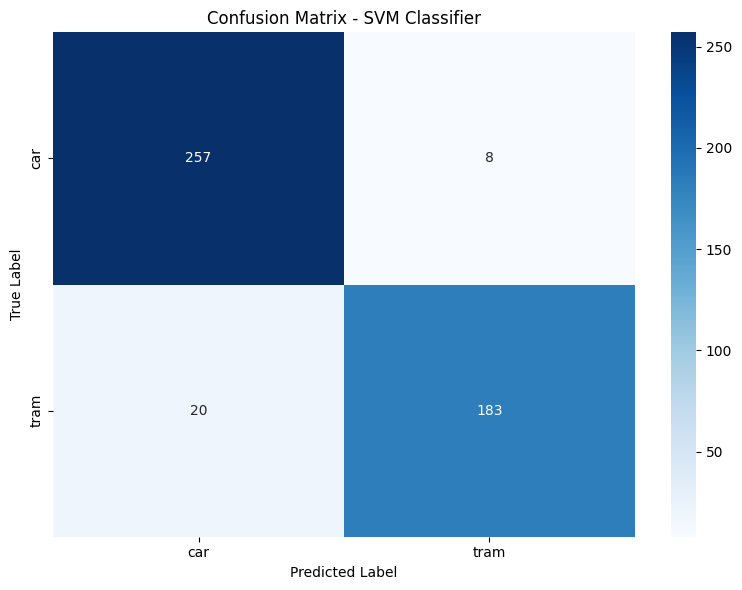

Confusion matrix saved to output/confusion_matrix.png


In [8]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

print(f"Confusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")

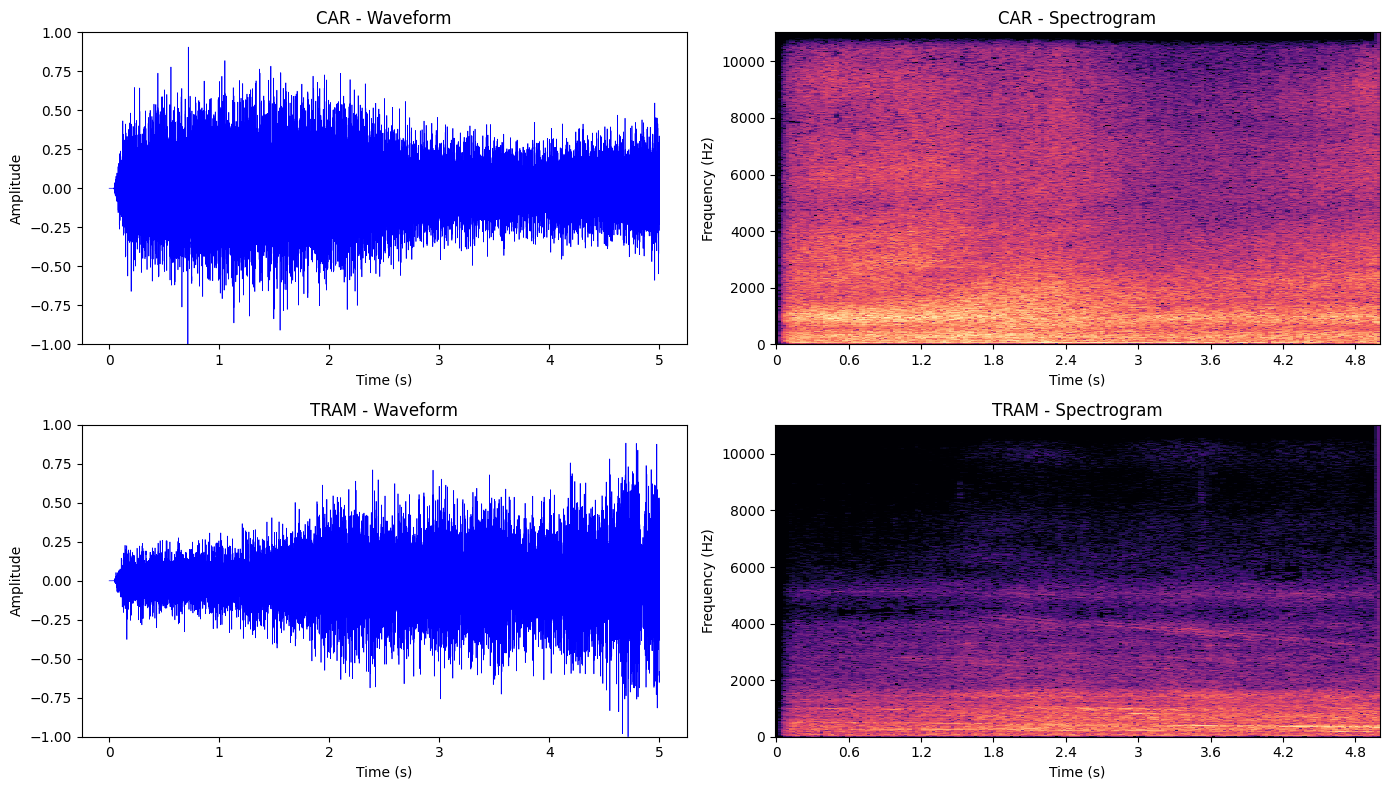

Waveforms and spectrograms saved to output/waveforms_spectrograms.png


In [9]:
# Plot sample waveforms from each class
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for idx, class_name in enumerate(CLASSES):
    # Find first sample of this class
    class_idx = labels.index(class_name)
    audio, sr, filename = processed_audio[class_idx]
    
    # Waveform
    axes[idx, 0].plot(np.linspace(0, DURATION, len(audio)), audio, color='blue', linewidth=0.5)
    axes[idx, 0].set_title(f'{class_name.upper()} - Waveform')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].set_ylim(-1, 1)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{class_name.upper()} - Spectrogram')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'waveforms_spectrograms.png'), dpi=150)
plt.show()

print(f"Waveforms and spectrograms saved to {OUTPUT_DIR}/waveforms_spectrograms.png")

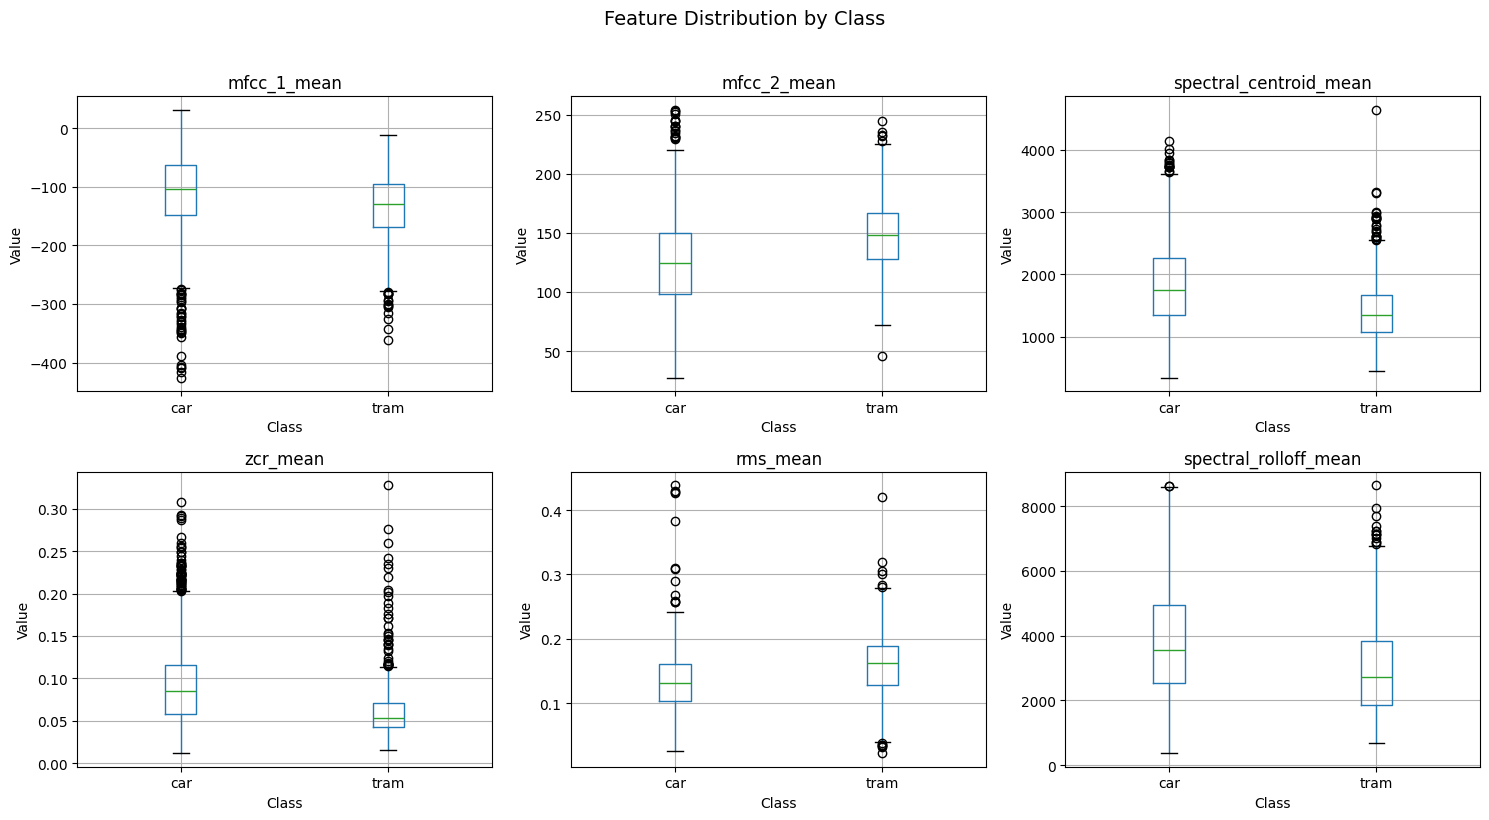

Feature distribution plot saved to output/feature_distribution.png


In [10]:
# Feature statistics comparison between classes
df_features = pd.DataFrame(X, columns=feature_names)
df_features['class'] = labels

# Plot mean feature values per class for key features
key_features = ['mfcc_1_mean', 'mfcc_2_mean', 'spectral_centroid_mean', 
                'zcr_mean', 'rms_mean', 'spectral_rolloff_mean']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    df_features.boxplot(column=feature, by='class', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Value')

plt.suptitle('Feature Distribution by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_distribution.png'), dpi=150)
plt.show()

print(f"Feature distribution plot saved to {OUTPUT_DIR}/feature_distribution.png")

In [11]:
# Summary statistics
print("="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  - Total samples: {len(audio_data)}")
print(f"  - Car samples: {labels.count('car')}")
print(f"  - Tram samples: {labels.count('tram')}")
print(f"  - Audio duration: {DURATION} seconds")
print(f"  - Sample rate: {SAMPLE_RATE} Hz")

print(f"\nFeatures:")
print(f"  - Total features: {len(feature_names)}")
print(f"  - MFCCs: {N_MFCC} coefficients (mean + std)")
print(f"  - Spectral features: centroid, ZCR, RMS, rolloff")

print(f"\nModel:")
print(f"  - Classifier: Support Vector Machine (SVM)")
print(f"  - Kernel: RBF")
print(f"  - Best C: {grid_search.best_params_['C']}")
print(f"  - Best gamma: {grid_search.best_params_['gamma']}")

print(f"\nResults:")
print(f"  - Accuracy: {accuracy*100:.2f}%")
print(f"  - Precision: {precision*100:.2f}%")
print(f"  - Recall: {recall*100:.2f}%")
print(f"  - F1-Score: {f1*100:.2f}%")

print("\n" + "="*60)
print("All results saved to the 'output' folder.")
print("="*60)

PROJECT SUMMARY

Dataset:
  - Total samples: 2339
  - Car samples: 1324
  - Tram samples: 1015
  - Audio duration: 5.0 seconds
  - Sample rate: 22050 Hz

Features:
  - Total features: 34
  - MFCCs: 13 coefficients (mean + std)
  - Spectral features: centroid, ZCR, RMS, rolloff

Model:
  - Classifier: Support Vector Machine (SVM)
  - Kernel: RBF
  - Best C: 1
  - Best gamma: scale

Results:
  - Accuracy: 94.02%
  - Precision: 94.09%
  - Recall: 94.02%
  - F1-Score: 93.99%

All results saved to the 'output' folder.
